# Regression with Different Output Format under Various Data Conditions

In this experience, we test the following output format for regression task under several different data coditions.
- Numerical output
- Regression as classification (grid-out)

The data coditions include:
- Sparse (few data)
- Grouped
  - Biased (parallel data)
  - Completely different mode, uncorrelated data (cross)
  - Partially diversed (split)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def draw_func(func_in, x_min=-5, x_max=5, mark='r--', linewidth=1, label='func'):
    n_sample = 100
    X_func = np.linspace(x_min, x_max, n_sample).reshape(n_sample, 1)
    y_func = func_in(X_func)
    plt.plot(X_func, y_func, mark, linewidth=linewidth, label=label)

Generate polynomial data

In [3]:
poly_a1 = 5.0
# poly_a1 = -10.0 # 5.0
def func_0(X): # Reference
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 2
def func_1(X): # Variation 1: parellel
    return 0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30
def func_2(X): # Variation 2: cross
    return -0.5 * X**3 + 0.5 * X**2 + (poly_a1)*X + 30
def func_3(X): # Variation 3: slightly split
    return 0.3 * X**3 + 1.0 * X**2 + (poly_a1)*X + 15 

In [4]:
func_dict = dict()
func_dict["f1"] = func_0
# func_dict["f2"] = func_1
# func_dict["f2"] = func_2
func_dict["f2"] = func_3

# Average line
func_dict["f_avg"] = ( lambda X: 0.5*func_dict["f1"](X) + 0.5*func_dict["f2"](X) )

In [5]:
def draw_normal_func(func_dict):
    draw_func(func_dict["f1"], mark='c:', label="f1")
    draw_func(func_dict["f2"], mark='g:', label="f2")
    draw_func(func_dict["f_avg"], mark='m--', label="f_avg")

In [6]:
np.random.seed(42)
m = 100 # 50 # 100 # 200
m_train = m // 5 * 4
print("(m, m_train) = (%d, %d)" % (m, m_train))

# Input
is_gapped = True
# is_gapped = False
#
if not is_gapped:
    X_data = 10 * np.random.rand(m, 1) - 5 # Note: X is randomly sampled, so we don't need to shuffle the data again
else:
    X_data = np.concatenate( (np.linspace(-5.0, -2.0, m//2), np.linspace(2.0, 5.0, m-m//2)) )
    X_data = X_data.reshape((m,1))
    np.random.shuffle(X_data)

# Output
is_multiout = True
# is_multiout = False
if is_multiout:
    m_h = m // 2
    X_data_1 = X_data[:m_h]
    X_data_2 = X_data[m_h:]
    y_data_pure_1 = func_dict["f1"](X_data_1) 
    y_data_pure_2 = func_dict["f2"](X_data_2) 
    y_data_pure = np.vstack([y_data_pure_1, y_data_pure_2])
    print("y_data_pure.shape = %s" % str(y_data_pure.shape))
else:        
    y_data_pure = func_dict["f_avg"](X_data)

# Label (+noise)
n_stddev = 2.0
# n_stddev = 10.0
y_data = y_data_pure + np.random.randn(m, 1) * n_stddev
print("y_data.shape = %s" % str(y_data.shape))

(m, m_train) = (100, 80)
y_data_pure.shape = (100, 1)
y_data.shape = (100, 1)


In [7]:
# Method 1: simply slice
# X_train = X_data[:m_train]
# y_train = y_data[:m_train]
# X_valid = X_data[m_train:]
# y_valid = y_data[m_train:]

# Method 2: shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)

(80, 1)


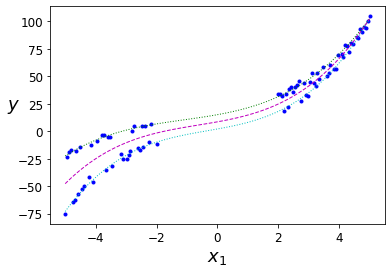

In [9]:
plt.plot(X_train, y_train, "b.")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Simple FCs (number --> number)

Build the regression model

In [10]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mean_absolute_error", optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
3/3 [==============================] - 1s 196ms/step - loss: 2476.4287 - val_loss: 1688.5684
Epoch 2/100
3/3 [==============================] - 0s 66ms/step - loss: 2425.6367 - val_loss: 1623.8064
Epoch 3/100
3/3 [==============================] - 0s 80ms/step - loss: 2324.0654 - val_loss: 1509.4767
Epoch 4/100
3/3 [==============================] - 0s 59ms/step - loss: 2139.8281 - val_loss: 1274.6306
Epoch 5/100
3/3 [==============================] - ETA: 0s - loss: 1689.17 - 0s 97ms/step - loss: 1689.1754 - val_loss: 782.7762
Epoch 6/100
3/3 [==============================] - 0s 64ms/step - loss: 767.0822 - val_loss: 287.0742
Epoch 7/100
3/3 [==============================] - 0s 91ms/step - loss: 483.8648 - val_loss: 637.1031
Epoch 8/100
3/3 [==============================] - 0s 65ms/step - loss: 633.8593 - val_loss: 182.3901
Epoch 9/100
3/3 [==============================] - 0s 63ms/step - loss: 317.9988 - val_loss: 380.0277
Epoch 10/100
3/3 [============================

3/3 [==============================] - 0s 90ms/step - loss: 165.8229 - val_loss: 155.0290
Epoch 79/100
3/3 [==============================] - 0s 106ms/step - loss: 165.6213 - val_loss: 149.2655
Epoch 80/100
3/3 [==============================] - ETA: 0s - loss: 230.137 - 0s 93ms/step - loss: 164.6862 - val_loss: 147.6510
Epoch 81/100
3/3 [==============================] - 0s 95ms/step - loss: 165.1405 - val_loss: 148.8251
Epoch 82/100
3/3 [==============================] - 0s 66ms/step - loss: 164.7066 - val_loss: 148.9024
Epoch 83/100
3/3 [==============================] - 0s 78ms/step - loss: 164.2004 - val_loss: 145.9845
Epoch 84/100
3/3 [==============================] - 0s 101ms/step - loss: 163.9532 - val_loss: 147.4969
Epoch 85/100
3/3 [==============================] - 0s 114ms/step - loss: 162.7691 - val_loss: 152.0681
Epoch 86/100
3/3 [==============================] - 0s 84ms/step - loss: 162.4401 - val_loss: 153.7601
Epoch 87/100
3/3 [==============================] - 0s 97

Plot the result

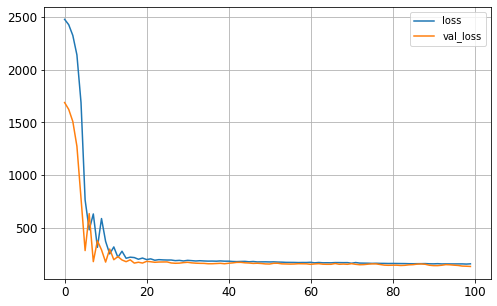

In [12]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

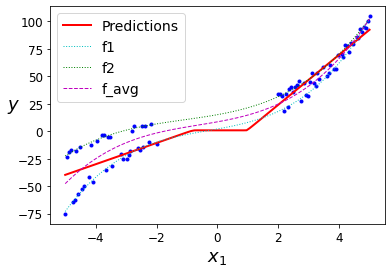

In [13]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Simulated CNN Feature Map (1-D grids, grid --> number)

In [14]:
class num2grid(keras.layers.Layer):
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape):
        #
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
#         print("self.x_grid.shape = %s" % str(self.x_grid.shape))
        #
        super().build(batch_input_shape) # must be at the end
        
    def call(self, X):
        '''
        Input shape:  (batch, X_chanel)
        Output shape: (batch, grid_unit) 
        
        self.x_grid shape: (grid_unit,)
        '''
        gauss_grid = tf.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
        print("X.shape = %s" % str(X.shape))
        print("gauss_grid.shape = %s" % str(gauss_grid.shape))
        return self.activation(gauss_grid)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "units": self.units,
                "x_min": self.x_min,
                "x_max": self.x_max,
                "sigma": self.sigma,
                "activation": keras.activations.serialize(self.activation)}

In [15]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss="mean_squared_error", optimizer=optimizer)
# optimizer = keras.optimizers.Adam(lr=0.01)
# model.compile(loss="mean_absolute_error", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 1s - loss: 2265.8582X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 1s 274ms/step - loss: 2483.8301 - val_loss: 1707.3610
Epoch 2/100
3/3 [==============================] - 0s 83ms/step - loss: 2394.6174 - val_loss: 1633.1882
Epoch 3/100
3/3 [==============================] - 0s 69ms/step - loss: 2181.1812 - val_loss: 1441.7583
Epoch 4/100
3/3 [==============================] - 0s 62ms/step - loss: 1593.1750 - val_loss: 1123.5048
Epoch 5/100
3/3 [==============================] - 0s 54ms/step - loss: 927.7184 - val_loss: 597.5143
Epoch 6/100
3/3 [==============================] - 0s 80ms/step - loss: 571.3521 - val_loss: 354.9579
Epoch 7/100
3/3 [==============================] - 0s 82ms/step - loss: 334.6880 - val_loss: 300.4417
Epoch 8/100
3/3 [==============================] - 0s 91ms/step - 

3/3 [==============================] - 0s 92ms/step - loss: 163.8037 - val_loss: 103.7723
Epoch 78/100
3/3 [==============================] - 0s 101ms/step - loss: 161.3919 - val_loss: 106.8044
Epoch 79/100
3/3 [==============================] - 0s 118ms/step - loss: 160.8492 - val_loss: 122.5711
Epoch 80/100
3/3 [==============================] - 0s 85ms/step - loss: 163.5078 - val_loss: 131.1806
Epoch 81/100
3/3 [==============================] - 0s 104ms/step - loss: 161.9193 - val_loss: 115.6319
Epoch 82/100
3/3 [==============================] - 0s 68ms/step - loss: 159.6745 - val_loss: 104.3445
Epoch 83/100
3/3 [==============================] - 0s 91ms/step - loss: 160.2429 - val_loss: 101.3537
Epoch 84/100
3/3 [==============================] - 0s 104ms/step - loss: 160.9782 - val_loss: 106.5788
Epoch 85/100
3/3 [==============================] - 0s 95ms/step - loss: 164.1592 - val_loss: 123.5578
Epoch 86/100
3/3 [==============================] - 0s 55ms/step - loss: 159.9436 

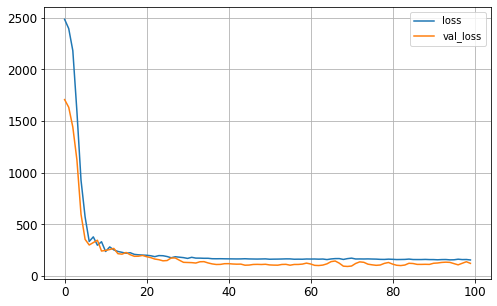

In [17]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


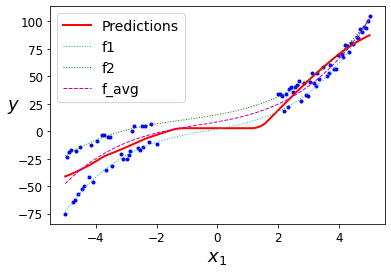

In [18]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new = model.predict(X_new)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func(model.predict, mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification (grid --> grid)

In [19]:
class num2grid_np():
    def __init__(self, units, x_min=-10, x_max=10, sigma=1.0):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.sigma = sigma
        self.sigma2 = self.sigma**2
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        print("self.x_grid = %s" % str(self.x_grid))
        
    def convert(self, X):
        gauss_grid = np.exp( -(self.x_grid - X)**2 / (2.0*self.sigma2) )
#         if len(gauss_grid.shape) == 1:
#             gauss_grid = gauss_grid.reshape([1,-1])
#         grid_sum = np.sum(gauss_grid, axis=1, keepdims=True)
        grid_sum = np.sum(gauss_grid, axis=-1, keepdims=True)
        gauss_grid = gauss_grid / grid_sum
        return gauss_grid
    
    def inv_convert(self, grid):
#         if len(grid.shape) == 1:
#             grid = grid.reshape([1,-1])
#         grid_sum = np.sum(grid, axis=1)
        grid_sum = np.sum(grid, axis=-1)
#         print(grid_sum)
        exp_num = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        return exp_num
    
    def get_statistic(self, grid):
        grid_sum = np.sum(grid, axis=-1)
        _mean = np.sum((self.x_grid * grid), axis=-1) / grid_sum # element-wise
        _var  = np.sum( ((self.x_grid.reshape((1,-1)) - _mean.reshape((-1,1)))**2 * grid), axis=-1) / grid_sum # element-wise
        # print("(_mean, _var) = (%f, %f)" % (_mean, _var))
        _stddev = np.sqrt(_var)
        return _mean, _stddev

In [20]:
# class_num = 10 # 10
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=20.0) # 20.0
# class_num = 20
# n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=15.0) # 20.0
class_num = 50
n2g = num2grid_np(class_num, x_min=-100.0, x_max=100.0, sigma=6.0) # 5.0 

self.x_grid = [-100.          -95.91836735  -91.83673469  -87.75510204  -83.67346939
  -79.59183673  -75.51020408  -71.42857143  -67.34693878  -63.26530612
  -59.18367347  -55.10204082  -51.02040816  -46.93877551  -42.85714286
  -38.7755102   -34.69387755  -30.6122449   -26.53061224  -22.44897959
  -18.36734694  -14.28571429  -10.20408163   -6.12244898   -2.04081633
    2.04081633    6.12244898   10.20408163   14.28571429   18.36734694
   22.44897959   26.53061224   30.6122449    34.69387755   38.7755102
   42.85714286   46.93877551   51.02040816   55.10204082   59.18367347
   63.26530612   67.34693878   71.42857143   75.51020408   79.59183673
   83.67346939   87.75510204   91.83673469   95.91836735  100.        ]


In [21]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2g.convert([[-1.2]])
print(grid_1)

[[3.57995092e-60 2.08100846e-55 7.61538914e-51 1.75441300e-46
  2.54444491e-42 2.32314196e-38 1.33530332e-34 4.83176258e-31
  1.10065884e-27 1.57841554e-24 1.42498879e-21 8.09884396e-19
  2.89771784e-16 6.52695532e-14 9.25521826e-12 8.26198061e-10
  4.64304784e-08 1.64264466e-06 3.65852120e-05 5.12966502e-04
  4.52786966e-03 2.51605603e-02 8.80173281e-02 1.93837381e-01
  2.68737559e-01 2.34552834e-01 1.28876722e-01 4.45789421e-02
  9.70748025e-03 1.33077537e-03 1.14848275e-04 6.23972825e-06
  2.13416679e-07 4.59528573e-09 6.22899760e-11 5.31551427e-13
  2.85557712e-15 9.65748361e-18 2.05615356e-20 2.75593262e-23
  2.32542921e-26 1.23526215e-29 4.13082337e-33 8.69632169e-37
  1.15254011e-40 9.61607812e-45 5.05081425e-49 1.67011468e-53
  3.47658354e-58 4.55596654e-63]]


In [22]:
n2g.inv_convert(grid_1)

array([-1.2])

In [23]:
n2g.get_statistic(grid_1)

(array([-1.2]), array([6.]))

### Convert the labels to grid (pre-processing)

In [24]:
y_train_grid = n2g.convert(y_train)
y_valid_grid = n2g.convert(y_valid)

In [25]:
print(y_train_grid.shape)
print(y_valid_grid.shape)

(80, 50)
(20, 50)


In [26]:
model = keras.models.Sequential([
#     keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(class_num, activation="softmax"),
])

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
history = model.fit(X_train, y_train_grid, epochs=100,
                    validation_data=(X_valid, y_valid_grid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 2s - loss: 3.9300X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 2s 308ms/step - loss: 3.9349 - val_loss: 3.9136
Epoch 2/100
3/3 [==============================] - 0s 88ms/step - loss: 3.8917 - val_loss: 3.8677
Epoch 3/100
3/3 [==============================] - 0s 67ms/step - loss: 3.8244 - val_loss: 3.8178
Epoch 4/100
3/3 [==============================] - 0s 81ms/step - loss: 3.7537 - val_loss: 3.7617
Epoch 5/100
3/3 [==============================] - 0s 110ms/step - loss: 3.6730 - val_loss: 3.7076
Epoch 6/100
3/3 [==============================] - 0s 100ms/step - loss: 3.5884 - val_loss: 3.6576
Epoch 7/100
3/3 [==============================] - 0s 96ms/step - loss: 3.5072 - val_loss: 3.5992
Epoch 8/100
3/3 [==============================] - 0s 103ms/step - loss: 3.4023 - val_loss: 3.4945
Epoc

Epoch 81/100
3/3 [==============================] - 0s 107ms/step - loss: 2.4151 - val_loss: 2.6253
Epoch 82/100
3/3 [==============================] - 0s 98ms/step - loss: 2.4164 - val_loss: 2.7160
Epoch 83/100
3/3 [==============================] - 0s 71ms/step - loss: 2.4146 - val_loss: 2.6593
Epoch 84/100
3/3 [==============================] - 0s 98ms/step - loss: 2.4205 - val_loss: 2.5810
Epoch 85/100
3/3 [==============================] - 0s 100ms/step - loss: 2.4166 - val_loss: 2.5977
Epoch 86/100
3/3 [==============================] - 0s 92ms/step - loss: 2.4147 - val_loss: 2.6732
Epoch 87/100
3/3 [==============================] - 0s 99ms/step - loss: 2.4136 - val_loss: 2.6944
Epoch 88/100
3/3 [==============================] - 0s 102ms/step - loss: 2.4300 - val_loss: 2.5771
Epoch 89/100
3/3 [==============================] - ETA: 0s - loss: 2.372 - 0s 95ms/step - loss: 2.4053 - val_loss: 2.6421
Epoch 90/100
3/3 [==============================] - 0s 109ms/step - loss: 2.4202 -

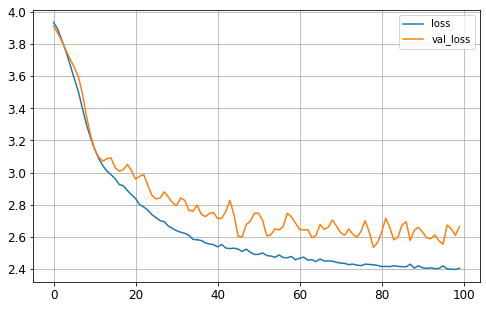

In [28]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


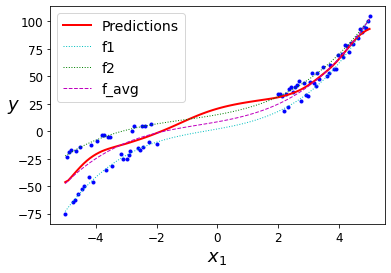

In [29]:
# X_new = np.linspace(-5, 5, 100).reshape(100, 1)
# y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
plt.plot(X_train, y_train, "b.")
# plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

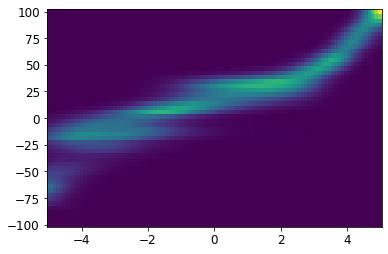

In [30]:
X_new = np.linspace(-5, 5, 100).reshape(100, 1)
y_new_proba = model.predict(X_new)
# y_new = n2g.inv_convert(y_new_proba)
#
xv, yv = np.meshgrid(X_new, np.linspace(n2g.x_min, n2g.x_max, n2g.units))
# print(xv)
# print(yv)
plt.pcolormesh(xv, yv, y_new_proba.T, shading="nearest")

### Draw the 1-sigma boundary line

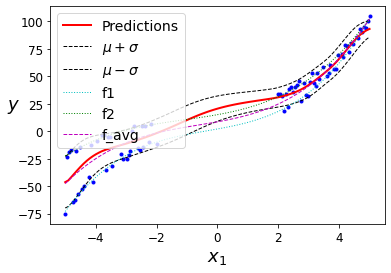

In [31]:
def n_sigma_boundary_line(X, n):
    _mean, _sigma = n2g.get_statistic(model.predict(X))
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: n2g.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

# Grid & Regression by Classification + Offset Estimation (grid --> grid,num)

In [32]:
class num2gridOffset_np():
    def __init__(self, units, x_min=-10, x_max=10):
        self.units = units
        self.x_min = x_min
        self.x_max = x_max
        self.x_grid = np.linspace(self.x_min, self.x_max, self.units, endpoint=True)
        # bins
        x_space = np.average(self.x_grid[1:] - self.x_grid[:-1])
        print("x_space = %f" % x_space)
        x_0 = self.x_grid[0] - 0.5 * x_space
        self.x_bins = [x_0 + _i*x_space for _i in range(len(self.x_grid)+1)]
        print("self.x_grid = %s" % str(self.x_grid))
#         print("self.x_bins = %s" % str(self.x_bins))
        
    def convert(self, X):
        '''
        Convert a batch of number to one-hot class and numerical offset to each grid's center
        (m, 1) --> (m, n_units, 2)
        '''
        X = np.array(X)
        if len(X.shape) <= 1:
            X = X.reshape((-1,1))
        idxs_bin = np.digitize(X, self.x_bins, right=False) 
        idxs_grid = (idxs_bin - 1) + 1*(idxs_bin<= 0)
        print(idxs_grid.shape)
        #
        batch_size = X.shape[0]
        grid = np.zeros((batch_size, self.units, 2))
        # Fill in the values
        grid[np.arange(batch_size), idxs_grid.reshape((-1,)), 0] = 1.0
        grid[np.arange(batch_size), :, 1] = X - self.x_grid.reshape((1,-1)) # Offset
        return grid
    
    def inv_convert(self, grid):
        idxs_grid = np.argmax(grid[...,0], axis=1)
        print(idxs_grid.shape)
        #
        batch_size = grid.shape[0]
        offset_est = grid[np.arange(batch_size),idxs_grid,1]
        print(offset_est.shape)
        num_est = self.x_grid[idxs_grid].reshape((1,-1)) + offset_est
        return num_est.reshape((-1,))

In [33]:
class_num = 10 # 10
n2go = num2gridOffset_np(class_num, x_min=-100.0, x_max=100.0) 

x_space = 22.222222
self.x_grid = [-100.          -77.77777778  -55.55555556  -33.33333333  -11.11111111
   11.11111111   33.33333333   55.55555556   77.77777778  100.        ]


In [34]:
# grid_1 = n2g.convert(-1.2)
grid_1 = n2go.convert([[-1.2], [50.5]])
print(grid_1)

(2, 1)
[[[   0.           98.8       ]
  [   0.           76.57777778]
  [   0.           54.35555556]
  [   0.           32.13333333]
  [   1.            9.91111111]
  [   0.          -12.31111111]
  [   0.          -34.53333333]
  [   0.          -56.75555556]
  [   0.          -78.97777778]
  [   0.         -101.2       ]]

 [[   0.          150.5       ]
  [   0.          128.27777778]
  [   0.          106.05555556]
  [   0.           83.83333333]
  [   0.           61.61111111]
  [   0.           39.38888889]
  [   0.           17.16666667]
  [   1.           -5.05555556]
  [   0.          -27.27777778]
  [   0.          -49.5       ]]]


In [35]:
n2go.inv_convert(grid_1)

(2,)
(2,)


array([-1.2, 50.5])

### Convert the labels to grid (pre-processing)

In [36]:
y_train_grid_offset = n2go.convert(y_train)
y_valid_grid_offset = n2go.convert(y_valid)

(80, 1)
(20, 1)


In [37]:
print(y_train_grid_offset.shape)
print(y_valid_grid_offset.shape)

(80, 10, 2)
(20, 10, 2)


In [38]:
inputs = keras.layers.Input(shape=X_train.shape[1:])
#
z = num2grid(5,x_min=-10, x_max=10, sigma=3.0)(inputs)
z = keras.layers.Dense(30, activation="selu")(z)
# Outputs
z_proba = keras.layers.Dense(30, activation="relu")(z)
z_proba  = keras.layers.Dense(class_num, activation="softmax")(z_proba)
z_offset = keras.layers.Dense(class_num, activation="relu")(z)
z_offset = keras.layers.Dense(class_num)(z_offset)
# Concatenate
z_proba  = keras.layers.Reshape([class_num,1])(z_proba)
z_offset = keras.layers.Reshape([class_num,1])(z_offset)
out_cat = keras.layers.Concatenate(axis=-1)([z_proba, z_offset])
#
# Models for trainig and real usage
model = keras.Model(inputs=[inputs], outputs=[out_cat])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [39]:
# Customized loss function

cce = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
# cce(y_true, y_pred).numpy()

def centerLoss_fn(y_true, y_pred):
    #
    y_true_proba = y_true[...,0]
    y_true_value = y_true[...,1]
    #
    y_pred_proba = y_pred[...,0]
    y_pred_value = y_pred[...,1]
    
    #
    cce_loss = cce(y_true_proba, y_pred_proba) / class_num
    #
    y_true_value_est = tf.reduce_sum((y_true_proba * y_true_value), axis=-1)
    y_pred_value_est = tf.reduce_sum((y_true_proba * y_pred_value), axis=-1)
#     y_pred_value_est = tf.reduce_sum((y_pred_proba * y_pred_value), axis=-1)
    value_loss = tf.abs(y_pred_value_est - y_true_value_est)
    
    # Total loss
#     return (0.5*cce_loss + 0.5*value_loss )
    return (0.2*cce_loss + 0.8*value_loss )
#     return (cce_loss)
#     return (value_loss )

In [40]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
model.compile(loss=centerLoss_fn, optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
# history = model.fit(X_train, y_train_grid_offset, epochs=100,
#                     validation_data=(X_valid, y_valid_grid_offset))

In [42]:
# import pandas as pd

# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# # plt.gca().set_ylim(0, 1)
# plt.show()

In [43]:
# plt.plot(X_train, y_train, "b.")
# draw_func((lambda X: n2go.inv_convert(model.predict(X)) ), mark='r-', linewidth=2, label="Predictions")
# draw_normal_func(func_dict)
# plt.xlabel("$x_1$", fontsize=18)
# plt.ylabel("$y$", rotation=0, fontsize=18)
# plt.legend(loc="upper left", fontsize=14)
# # plt.axis([-3, 3, 0, 10])
# plt.show()

# Parametric Uncertainty/Distribution Estimation

In this section, we try to estimate uncertainty (actually, fit the dataset distribution) with parametric reprecentation of a distribution instead of a discretized non-parametric representation.

Possible solution includes
- Quantile estimation with pinball loss (statistic)
- Guassian distribution (fit a prabability distribution)

## Quantile Estimation with Pinball Loss (grid --> parameters)

Quantile estimation and pinball loss is based on the concept of statistic, which predict the value based on the rank of samples in the dataset.

The outputs of the model are $(y_{10}, y_{90})$, 10% quantile prediction and 90% quantile prediction, respectively.

In [44]:
# quantile_list = [0.5]
quantile_list = [0.1, 0.9]
# quantile_list = [0.25, 0.75]
# quantile_list = [0.1, 0.5, 0.9]
# quantile_list = [0.1, 0.3, 0.7, 0.9]
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9] # remove 0.5
# quantile_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num_quantile = len(quantile_list)

In [45]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
#     keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(num_quantile) # (y10, y90)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [46]:
# Customized loss function
def pinballLoss_fn(y_true, y_pred, tau):
    # tau: quantile, tau in [0.0, 1.0]
    # y_true: label mean
    # y_pred: predicted tau quantile
    _q = y_true - y_pred
    return tf.math.maximum( (tau*_q), ((tau-1.0)*_q))
    
def pinballLoss_10_90_fn(y_true, y_pred):
    #
    return pinballLoss_fn(y_true, y_pred[:,0:1], 0.1) + pinballLoss_fn(y_true, y_pred[:,1:2], 0.9)

def pinballLoss_full_fn(y_true, y_pred):
    #
    pinball_losses = tf.stack( [pinballLoss_fn(y_true, y_pred[:, _i:(_i+1)], _tau) for _i, _tau in enumerate(quantile_list)], axis=1)
    return tf.reduce_sum(pinball_losses, axis=1)

In [47]:
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
# model.compile(loss=pinballLoss_10_90_fn, optimizer=optimizer)
model.compile(loss=pinballLoss_full_fn, optimizer=optimizer)

In [48]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid))

Epoch 1/100
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 2s - loss: 40.2469X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 2s 230ms/step - loss: 41.9406 - val_loss: 33.9732
Epoch 2/100
3/3 [==============================] - 0s 100ms/step - loss: 41.2072 - val_loss: 32.8154
Epoch 3/100
3/3 [==============================] - 0s 119ms/step - loss: 39.5069 - val_loss: 30.1027
Epoch 4/100
3/3 [==============================] - 0s 68ms/step - loss: 35.0968 - val_loss: 23.2422
Epoch 5/100
3/3 [==============================] - 0s 94ms/step - loss: 24.0311 - val_loss: 11.7026
Epoch 6/100
3/3 [==============================] - 0s 75ms/step - loss: 13.7562 - val_loss: 15.6376
Epoch 7/100
3/3 [==============================] - 0s 60ms/step - loss: 17.3653 - val_loss: 17.3301
Epoch 8/100
3/3 [==============================] - 0s 73ms/step - loss: 17.4979 - val_lo

3/3 [==============================] - 0s 104ms/step - loss: 2.7220 - val_loss: 2.5127
Epoch 81/100
3/3 [==============================] - 0s 105ms/step - loss: 2.8243 - val_loss: 2.8737
Epoch 82/100
3/3 [==============================] - 0s 116ms/step - loss: 2.8800 - val_loss: 3.1140
Epoch 83/100
3/3 [==============================] - 0s 84ms/step - loss: 3.0240 - val_loss: 2.8312
Epoch 84/100
3/3 [==============================] - 0s 80ms/step - loss: 3.1726 - val_loss: 2.7787
Epoch 85/100
3/3 [==============================] - 0s 83ms/step - loss: 2.6926 - val_loss: 2.9781
Epoch 86/100
3/3 [==============================] - 0s 75ms/step - loss: 2.8932 - val_loss: 2.7385
Epoch 87/100
3/3 [==============================] - 0s 95ms/step - loss: 2.6279 - val_loss: 2.6251
Epoch 88/100
3/3 [==============================] - 0s 76ms/step - loss: 3.1574 - val_loss: 2.6886
Epoch 89/100
3/3 [==============================] - 0s 54ms/step - loss: 2.9891 - val_loss: 2.9653
Epoch 90/100
3/3 [==

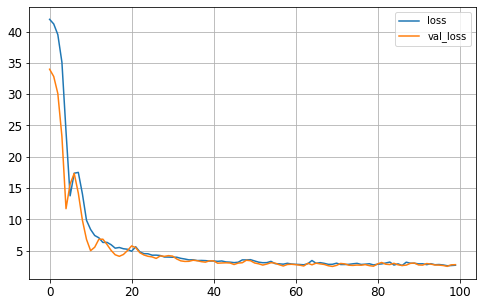

In [49]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


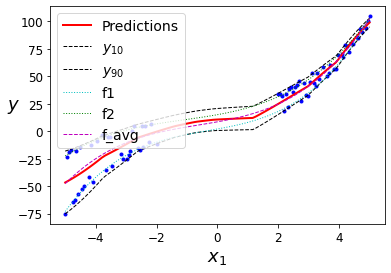

In [50]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: np.average(model.predict(X), axis=-1) ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: model.predict(X)[:,0] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[0]*100))
draw_func((lambda X: model.predict(X)[:,-1] ), mark='k--', linewidth=1, label="$y_{%d}$" % (quantile_list[-1]*100))
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

## Gaussian Estimation with Gaussian Loss (grid-->parameters)

Gaussain estimation requires the model to predict the mean and variance of a Gaussian distribution of the random variable regarded. The training purpose is to fit a Gaussian distribution to the data distribution (which is not necessay distributed as Gaussian).

One possible solution, derived by BensonHuang, is that the model estimates $(\mu, z)$, where $z=\alpha ^{-1}log(\sigma)$.
The associated loss function can be $L_G(y, (\mu,z)) = 0.5e^{-2\alpha z}(y-\mu)^2 + \alpha z$.

In [51]:
alpha = 1.0
# alpha = 0.01
# alpha = 0.001

In [52]:
model = keras.models.Sequential([
    num2grid(5,x_min=-10, x_max=10, sigma=3.0, input_shape=X_train.shape[1:]),
#     keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(60, activation="relu"),
#     keras.layers.Dense(30, activation=keras.layers.LeakyReLU(alpha=0.2) ),
#     keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(2) # (mu, z)
])

X.shape = (None, 1)
gauss_grid.shape = (None, 5)


In [53]:
# Customized loss function
print("alpha = %f" % alpha)

def GaussianLoss_fn(y_true, y_pred):
    # y_true: label 
    # y_pred: (mu, z), z=log(sigma)
    mu = y_pred[:, 0:1]
    z  = y_pred[:, 1:2]
    #
    en2z = tf.math.exp((-2.0*alpha)*z)
    ymu2 = (y_true - mu)**2
    return (0.5*en2z*ymu2 + alpha*z)

alpha = 1.000000


In [54]:
# Learning rate scheduler
learning_rate_switch_epoch_list = [30, 45]
learning_rate_list = [0.001, 0.01, 0.1]
# learning_rate_switch_epoch_list = [30, 80]
# learning_rate_list = [0.01, 0.1, 0.01]
#
def piecewise_constant_fn(epoch):
    for _i, epoch_s in enumerate(learning_rate_switch_epoch_list):
        if epoch < epoch_s:
            return learning_rate_list[_i]
    return learning_rate_list[-1]

lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

Third training with even greater speed

In [55]:
# optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9)
optimizer = keras.optimizers.Adam(lr=0.1)
model.compile(loss=GaussianLoss_fn, optimizer=optimizer)

/home/benson516/ml/my_env/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid))

Epoch 1/200
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
X.shape = (None, 1)
gauss_grid.shape = (None, 5)
1/3 [=========>....................] - ETA: 3s - loss: 1283.2878X.shape = (None, 1)
gauss_grid.shape = (None, 5)
3/3 [==============================] - 2s 278ms/step - loss: 520.1695 - val_loss: 6.6682
Epoch 2/200
3/3 [==============================] - 0s 110ms/step - loss: 8.2657 - val_loss: 12.2321
Epoch 3/200
3/3 [==============================] - 0s 95ms/step - loss: 13.4443 - val_loss: 16.3032
Epoch 4/200
3/3 [==============================] - 0s 113ms/step - loss: 17.1652 - val_loss: 19.0510
Epoch 5/200
3/3 [==============================] - 0s 85ms/step - loss: 19.6211 - val_loss: 20.7208
Epoch 6/200
3/3 [==============================] - 0s 58ms/step - loss: 21.0567 - val_loss: 21.5410
Epoch 7/200
3/3 [==============================] - 0s 66ms/step - loss: 21.6796 - val_loss: 21.6926
Epoch 8/200
3/3 [==============================] - 0s 76ms/step - loss: 21.6781 - val_l

3/3 [==============================] - 0s 122ms/step - loss: 3.3732 - val_loss: 3.5297
Epoch 82/200
3/3 [==============================] - 0s 83ms/step - loss: 3.4379 - val_loss: 3.3537
Epoch 83/200
3/3 [==============================] - 0s 119ms/step - loss: 3.5527 - val_loss: 3.4354
Epoch 84/200
3/3 [==============================] - 0s 108ms/step - loss: 3.3833 - val_loss: 3.7492
Epoch 85/200
3/3 [==============================] - 0s 118ms/step - loss: 3.4574 - val_loss: 3.3635
Epoch 86/200
3/3 [==============================] - 0s 115ms/step - loss: 3.5595 - val_loss: 3.5185
Epoch 87/200
3/3 [==============================] - 0s 106ms/step - loss: 3.3909 - val_loss: 3.4505
Epoch 88/200
3/3 [==============================] - 0s 129ms/step - loss: 3.5202 - val_loss: 3.4145
Epoch 89/200
3/3 [==============================] - 0s 117ms/step - loss: 3.6598 - val_loss: 3.5387
Epoch 90/200
3/3 [==============================] - 0s 122ms/step - loss: 3.5703 - val_loss: 3.7252
Epoch 91/200
3

In [ ]:
# history = model.fit(X_train, y_train, epochs=145,
#                     validation_data=(X_valid, y_valid), callbacks=[lr_scheduler])

In [ ]:
import pandas as pd

# print(history.history)
try:
    lr_list = history.history["lr"]
    del(history.history["lr"])
except:
    pass

pd.DataFrame(history.history)[50:].plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
plt.plot(X_train, y_train, "b.")
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()

### Draw the 1-sigma boundary line

In [ ]:
def n_sigma_boundary_line(X, n):
    _y = model.predict(X)
    _mean, _z = _y[:,0:1], _y[:,1:2]
    _sigma = np.exp(alpha*_z)
    return( _mean + n*_sigma)

plt.plot(X_train, y_train, "b.")
#
draw_func((lambda X: model.predict(X)[:,0] ), mark='r-', linewidth=2, label="Predictions")
draw_func((lambda X: n_sigma_boundary_line(X, +1.0) ), mark='k--', linewidth=1, label="$\mu+\sigma$")
draw_func((lambda X: n_sigma_boundary_line(X, -1.0) ), mark='k--', linewidth=1, label="$\mu-\sigma$")
#
draw_normal_func(func_dict)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
# plt.axis([-3, 3, 0, 10])
plt.show()